In [159]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error 

In [162]:
# First we handle the energy prices
df_energy2019 = pd.read_csv('Data/energy_2019.csv')[['Unnamed: 0', 'FI']]
df_energy2020 = pd.read_csv('Data/energy_2020.csv')[['Unnamed: 0', 'FI']]
df_energy2021 = pd.read_csv('Data/energy_2021.csv')[['Unnamed: 0', 'FI']]
df_energy2019.columns = ['Date', 'Price']
df_energy2020.columns = ['Date', 'Price']
df_energy2021.columns = ['Date', 'Price']
energy = [df_energy2019, df_energy2020, df_energy2021]

# Combine energy prices into one df
df_energy = pd.concat(energy)
# Change all commas into dots and then turn data into float from string
df_energy['Price'] = df_energy['Price'].apply(lambda x: x.replace(',','.'))
df_energy['Price'] = df_energy['Price'].astype(float)

# Then we handle the weather data
df_weather = pd.read_csv('Data/weather.csv')
df_weather.drop(columns=['Time', 'Time zone'], inplace=True)
# Add date column and remove old columns
date_array = df_weather["d"].astype(str)+'-'+df_weather["m"].astype(str)+'-'+df_weather["Year"].astype(str)
df_weather.insert(0, "Date", date_array)
df_weather.drop(['Year', 'm', 'd'], axis=1, inplace=True)
df_weather.columns = ['Date', 'Rain', "Temp"]

# Handle wind data
df_wind = pd.read_csv('Data/wind.csv')[['Year', 'm', 'd', 'Wind speed (m/s)']]
d_a = df_wind["d"].apply(lambda x: str(x).zfill(2))
d_m = df_wind["m"].apply(lambda x: str(x).zfill(2))
date_array = d_a.astype(str)+'-'+d_m.astype(str)+'-'+df_wind["Year"].astype(str)
df_wind.insert(0, "Date", date_array)
df_wind.drop(['Year', 'm', 'd'], axis=1, inplace=True)
df_wind.columns = ['Date', "Wind"]
df_wind = df_wind.groupby('Date').mean()

# Put everything together
df = df_energy
df["Temp"] = df_weather["Temp"]
df['tr_Temp'] = df_energy.iloc[:,2].rolling(window=4).mean().shift()
df['tr_Price'] = df_energy.iloc[:,1].rolling(window=4).mean().shift()

df['PriceRatio'] = (df['Price']/df['tr_Price'] - 1)
df['TempDif'] = df["Temp"] - df["tr_Temp"]

df = pd.merge(df, df_wind, on="Date")
df = df.iloc[4: , :]
df = df[df['PriceRatio'] < 3]


In [163]:
# Create feature and label matrix
X = df['TempDif'].to_numpy()
y = df['PriceRatio'].to_numpy()
X = X.reshape(-1, 1)

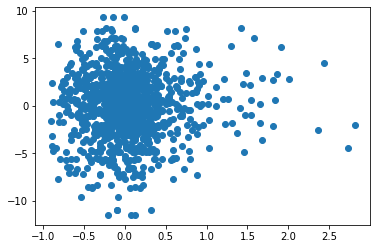

In [164]:
# Plot the data
plt.scatter(df['PriceRatio'],df['TempDif'])
plt.show()

We now split the data into Test data and Remaining data <br>
The remainig data will be used for training and the test data will give us the final error value.


## Linear

In [165]:
# Defining the kfold object we will use for cross validation
k, shuffle, seed = 3, True, 42
kfold = KFold(n_splits=k, shuffle=shuffle, random_state=seed)

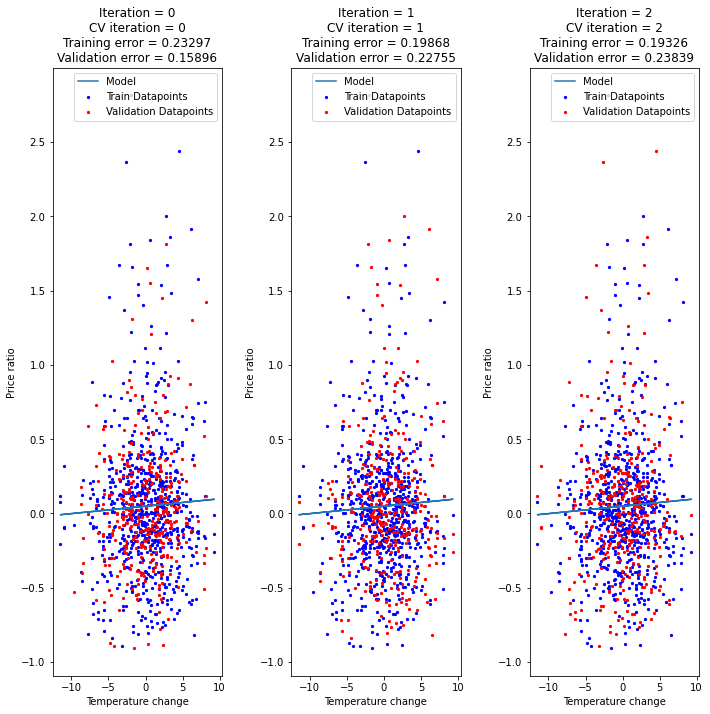

In [166]:
# Define lists for tr and val errors
tr_errors = []        
val_errors = []
counter = 0

plt.figure(figsize=(10, 10))
# Loop through the kfolds
for j, (train_indices, val_indices) in enumerate(kfold.split(X)):
    
    plt.subplot(1, k, counter+1)   # choose the subplot

    # Define training and validation data

    X_train, y_train, X_val, y_val = X[train_indices], y[train_indices], X[val_indices], y[val_indices]

    regr = LinearRegression()
    regr.fit(X, y)

    # Compute errors on folded train and validation data
    y_pred_train = regr.predict(X_train)    # predict using the linear model
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = regr.predict(X_val) # predict labels for the validation data using the linear model 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error

    tr_errors.append(tr_error)
    val_errors.append(val_error)
    
    plt.tight_layout(pad=1, w_pad=2, h_pad=2)
    plt.plot(X, regr.predict(X), label="Model")
    plt.scatter(X_train, y_train, color="b", s=5, label="Train Datapoints")
    plt.scatter(X_val, y_val, color="r", s=5, label="Validation Datapoints") 
    plt.xlabel('Temperature change')
    plt.ylabel('Price ratio')
    plt.legend(loc="best") 
    plt.title(f'Iteration = {counter}\nCV iteration = {j}\nTraining error = {tr_error:.5}\nValidation error = {val_error:.5}')
    counter += 1

plt.show()

In [167]:
# Now calculate average tr and val error
lin_average_train_error = np.mean(tr_errors)
lin_average_val_error = np.mean(val_errors)

print(f"Lin avg train error = {lin_average_train_error}, "
      f"Lin avg val error = {lin_average_val_error}")

Lin avg train error = 0.20830235711649617, Lin avg val error = 0.20830235711649614


 ## Then try the same but with Huber Regression

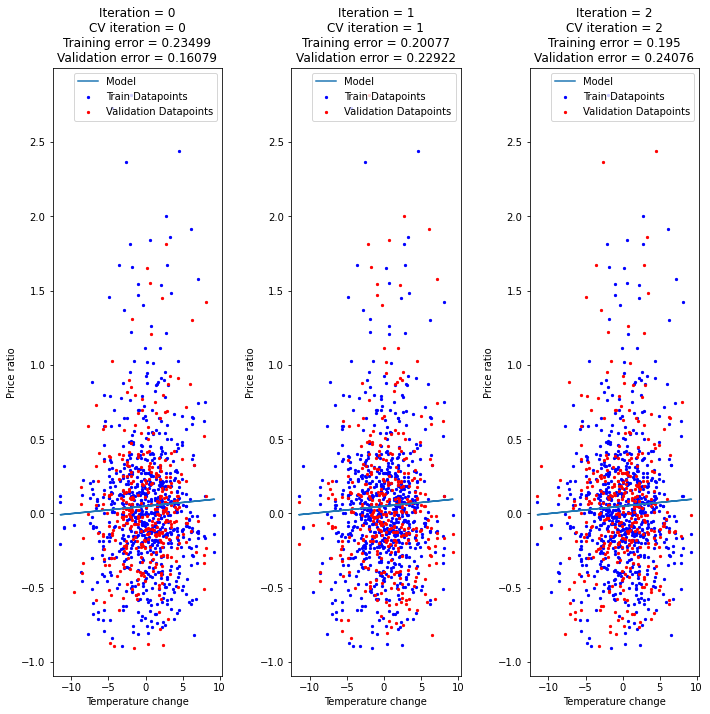

In [168]:
# Define lists for tr and val errors
H_tr_errors = []        
H_val_errors = []
counter = 0

plt.figure(figsize=(10, 10))
# Loop through the kfolds
for j, (train_indices, val_indices) in enumerate(kfold.split(X)):
    
    plt.subplot(1, k, counter+1)   # choose the subplot

    # Define training and validation data

    X_train, y_train, X_val, y_val = X[train_indices], y[train_indices], X[val_indices], y[val_indices]

    Hregr = HuberRegressor()
    Hregr.fit(X, y)

    # Compute errors on folded train and validation data
    y_pred_train = Hregr.predict(X_train)    # predict using the linear model
    H_tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = Hregr.predict(X_val) # predict labels for the validation data using the linear model 
    H_val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error

    H_tr_errors.append(tr_error)
    H_val_errors.append(val_error)
    
    plt.tight_layout(pad=1, w_pad=2, h_pad=2)
    plt.plot(X, regr.predict(X), label="Model")
    plt.scatter(X_train, y_train, color="b", s=5, label="Train Datapoints")
    plt.scatter(X_val, y_val, color="r", s=5, label="Validation Datapoints") 
    plt.xlabel('Temperature change')
    plt.ylabel('Price ratio')
    plt.legend(loc="best") 
    plt.title(f'Iteration = {counter}\nCV iteration = {j}\nTraining error = {H_tr_error:.5}\nValidation error = {H_val_error:.5}')
    counter += 1

plt.show()

In [169]:
# Now calculate average tr and val error
hub_average_train_error = np.mean(H_tr_errors)
hub_average_val_error = np.mean(H_val_errors)

print(f"Hub avg train error = {hub_average_train_error}, "
      f"Hub avg val error = {hub_average_val_error}")

Hub avg train error = 0.19325730376787556, Hub avg val error = 0.23839246381373744


## Then lastly use Polynomial model to try and improve our model

### The polynomial degrees tested will be 3, 5 and 9


In [ ]:
degrees = [3, 5, 9]    

poly_tr_errors = {}          
poly_val_errors = {}

plt.figure(figsize=(15, 15))    # create a new figure with size 8*20

# Go through every degree and perform KFold on everyone
for i, degree in enumerate(degrees):
    poly_tr_errors[degree] = []
    poly_val_errors[degree] = []
    
    # Loop through the kfolds
    for j, (train_indices, val_indices) in enumerate(kfold.split(X)): 
        plt.subplot(len(degrees), k, i * k + j + 1)   # choose the subplot
        
        # Define training and validation data
        X_train, y_train, X_val, y_val = X[train_indices], y[train_indices], X[val_indices], y[val_indices]
        
        lin_regr = LinearRegression(fit_intercept=False)
        poly = PolynomialFeatures(degree=degree)    # generate polynomial features
        X_train_poly = poly.fit_transform(X_train)    # fit the raw features
        lin_regr.fit(X_train_poly, y_train)    # apply linear regression

        # Compute errors on folded train and validation data
        y_pred_train = lin_regr.predict(X_train_poly)    # predict -> training
        poly_tr_error = mean_squared_error(y_train, y_pred_train)    # training error
        X_val_poly = poly.transform(X_val) # fit -> validation data 
        y_pred_val = lin_regr.predict(X_val_poly) # predict -> validation data
        poly_val_error = mean_squared_error(y_val, y_pred_val) # validation error
        
        # Add given errors to our collection
        poly_tr_errors[degree].append(poly_tr_error)
        poly_val_errors[degree].append(poly_val_error)

        # Plot
        plt.tight_layout()
        plt.plot(X, lin_regr.predict(poly.transform(X.reshape(-1, 1))), label="Model")
        plt.scatter(X_train, y_train, color="b", s=10, label="Train Datapoints")
        plt.scatter(X_val, y_val, color="r", s=10, label="Validation Datapoints")
        plt.xlabel('mintmp')
        plt.ylabel('maxtmp')
        plt.legend(loc="best")
        plt.title(f'Polynomial degree = {degree}\nCV iteration = {j}\nTraining error = {poly_tr_error:.5}\nValidation error = {poly_val_error:.5}')    # set the title


plt.show()

In [ ]:
# Now calculate average tr and val error
poly_average_train_error, poly_average_val_error = {}, {}
for degree in degrees:
    poly_average_train_error[degree] = np.mean(poly_tr_errors[degree])
    poly_average_val_error[degree] = np.mean(poly_val_errors[degree])
   
    print(f"Degree {degree}, avg train error = {poly_average_train_error[degree]:.5f}, "
          f"avg val error = {poly_average_val_error[degree]:.5f}")

## Now we can present all of the models in table-format

In [ ]:
d = pd.DataFrame({'Model' : ['Linear', 'Huber', 'Poly: 3', 'Poly: 5', 'Poly: 9'],
        'Training error' : [lin_average_train_error,
                            hub_average_train_error,
                            poly_average_train_error[3], 
                            poly_average_train_error[5],
                            poly_average_train_error[9]],
        
        'Validation error' : [lin_average_val_error,
                              hub_average_val_error,
                              poly_average_val_error[3],
                              poly_average_val_error[5],
                              poly_average_val_error[9]],
        'Difference' : [lin_average_train_error - lin_average_val_error,
                        hub_average_train_error - hub_average_val_error,
                        poly_average_train_error[3] - poly_average_val_error[3],
                        poly_average_train_error[5] - poly_average_val_error[5],
                        poly_average_train_error[9] - poly_average_val_error[9]]})
d

## Based on this we can evaluate that the Linear model is the best one
<br>

### Now we can calculate the error on the test set

In [154]:
regr = LinearRegression()
regr.fit(X_test, y_test)

# Compute errors on folded train and validation data
y_pred_test = regr.predict(X_test)    # predict using the linear model
test_error = mean_squared_error(y_test, y_pred_test)    # calculate the training error

In [142]:
test_error

0.21549751809392723